# LightGBM

- **Purpose:** Understand Random Forest and XGB models by applying them to one example
- **Data:** Combined Cycle Power Plant Data Set. For more info follow <a href="https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant" target="_blank">this link</a> 
- **Author:** Emily Diaz
- **Date:** November 25th of 2020 

Useful links (used as reference for this notebook): 
- https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html
- https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/sklearn_example.py

This notebook is divided into the following sections/steps:
1. [Libraries](#libraries)
2. [Load data](#loaddata)
3. [Data Exploration](#exploration)
4. [Data Preparation](#dataprep)
5. [Model - LightGBM](#lgbm)

<a id="libraries"></a>
# 1. Libraries

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler # scaling data to 0-1 range
from sklearn.model_selection import train_test_split #train/test split
import matplotlib.pyplot as plt # plot
import shap # shap values for interpretation
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV # Parameter tuning
import lightgbm
import random

In [28]:
# Function for mape calculation
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [29]:
# Seed 
seed = random.seed(1234)

In [30]:
!pwd

/Users/natashadiaz/Documents/ml_models_tutorials


<a id="loaddata"></a>
# 2. Load Data

In [31]:
df = pd.read_excel('./1_Input/CCPP/Folds5x2_pp.xlsx', sheet_name='Sheet5')
print(df.shape)
df.head()


(9568, 5)


,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


<a id="exploration"></a>
# 3. Exploration

In [32]:
df.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


<a id="dataprep"></a>
# 4. Data Preparation

Split into X and Y

In [33]:
X = df.drop(columns= ['PE'])
y = df['PE']

Scale data

In [34]:
# Initialize min/max scaler: this takes data to a 0 to 1 scale
scaler = MinMaxScaler()

In [35]:
scaled_X = scaler.fit_transform(X)

Test/train

In [36]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

<a id="lgbm"></a>
# 5. Model - LightGBM

For parameter specification: https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [37]:
# Instantiate model with 1000 decision trees
lgbm = lightgbm.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)

Train model without parameter tuning

In [38]:
# Train the model on training data
lgbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='mape',
        early_stopping_rounds=5)

[1]	valid_0's mape: 0.0307394	valid_0's l2: 259.99
Training until validation scores don't improve for 5 rounds
[2]	valid_0's mape: 0.0292669	valid_0's l2: 236.354
[3]	valid_0's mape: 0.0278699	valid_0's l2: 215.004
[4]	valid_0's mape: 0.0265449	valid_0's l2: 195.687
[5]	valid_0's mape: 0.0252853	valid_0's l2: 178.225
[6]	valid_0's mape: 0.024102	valid_0's l2: 162.499
[7]	valid_0's mape: 0.0229752	valid_0's l2: 148.269
[8]	valid_0's mape: 0.0219144	valid_0's l2: 135.435
[9]	valid_0's mape: 0.0209042	valid_0's l2: 123.807
[10]	valid_0's mape: 0.0199527	valid_0's l2: 113.328
[11]	valid_0's mape: 0.019056	valid_0's l2: 103.843
[12]	valid_0's mape: 0.0182118	valid_0's l2: 95.3158
[13]	valid_0's mape: 0.0174163	valid_0's l2: 87.5928
[14]	valid_0's mape: 0.0166682	valid_0's l2: 80.6037
[15]	valid_0's mape: 0.0159604	valid_0's l2: 74.2557
[16]	valid_0's mape: 0.0152947	valid_0's l2: 68.5477
[17]	valid_0's mape: 0.0146672	valid_0's l2: 63.3296
[18]	valid_0's mape: 0.0140822	valid_0's l2: 58.664

LGBMRegressor(learning_rate=0.05, n_estimators=20)

Predictions on test

In [39]:
y_pred = lgbm.predict(X_test)


Model performance metrics

In [40]:
print('Train MAPE: ' + str(mape(y_train, lgbm.predict(X_train))))
print('Test MAPE: ' + str(mape(y_test, y_pred)))

Train MAPE: 1.3185171657147923
Test MAPE: 1.3003514767510471


In [41]:
print('Train R2: ' + str(r2_score(y_train, lgbm.predict(X_train))))
print('Test R2: ' + str(r2_score(y_test, y_pred)))

Train R2: 0.8223681908075234
Test R2: 0.8231868146067918


Looking at MAPE, looks like model is overfitting (because it's twice but on the absolutes both are below 1% so they are fine)

Hyperparameter tuning

For more info on the parameters that can be tuned: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [42]:
estimator = lightgbm.LGBMRegressor()

In [43]:
# Find the best parameters for the model
parameters = {
    'num_leaves':[15,25,30,35,40],
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [5, 10, 25, 50], # The number of trees in the forest.
    'max_depth': [3,4,5]
}
gridrf = GridSearchCV(estimator, parameters, cv = 3, n_jobs = -1, verbose = 1)
gridrf.fit(X_train, y_train)
gridrf.best_params_

Fitting 3 folds for each of 180 candidates, totalling 540 fits


{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'num_leaves': 35}

In [44]:
# Extract best model
best_model = gridrf.best_estimator_
# Evaluate test set accuracy
test_acc = best_model.score(X_test,y_test)
# Print test set accuracy
print("Test set accuracy of best model: {:.3f}".format(test_acc))

Test set accuracy of best model: 0.955


In [45]:
print('Train MAPE: ' + str(mape(y_train, best_model.predict(X_train))))
print('Test MAPE: ' + str(mape(y_test, best_model.predict(X_test))))

Train MAPE: 0.5761301552544705
Test MAPE: 0.6011371949340386


Variable importance

<AxesSubplot:>

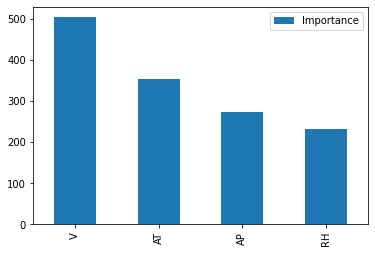

In [46]:
# Variable importance
importance = best_model.feature_importances_
# Adding name of cols
importance = pd.DataFrame(importance, index=X.columns, 
                          columns=["Importance"])

# Sort values
importance = importance.sort_values(by=['Importance'], ascending=False)

importance.plot.bar()

In [47]:
pwd

'/Users/natashadiaz/Documents/ml_models_tutorials'

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Natasha_Diaz/Box Sync/DS Sessions/ex.png'

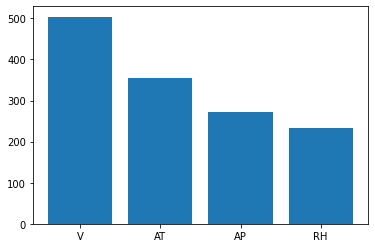

In [48]:
plt.bar(importance.index, importance.Importance)
plt.savefig('/Users/Natasha_Diaz/Box Sync/DS Sessions/ex.png')

### Shap values

more info here: https://github.com/slundberg/shap

In [ ]:
# load JS visualization code to notebook
shap.initjs()

In [ ]:
# Explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(scaled_X)


In [ ]:
# Visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], scaled_X[0], feature_names=X.columns)

In [ ]:
scaled_X[1]

array([0.6184136 , 0.58950178, 0.45805494, 0.65201072])

In [ ]:
# Visualize the training set predictions - 100 of the total

shap.force_plot(explainer.expected_value, shap_values[:100,:], scaled_X[:100], feature_names=X.columns)

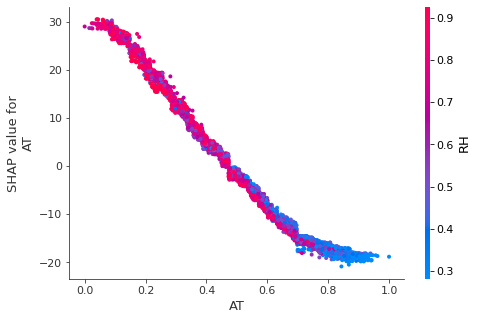

In [ ]:
# Create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("AT", shap_values, scaled_X, feature_names=X.columns)

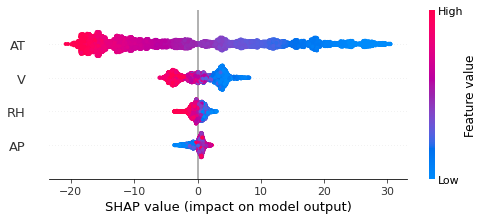

In [ ]:
# Summarize the effects of all the features
shap.summary_plot(shap_values, scaled_X, feature_names=X.columns)